# Chapter6 カーネル法

#### カーネル関数
$$
k(\bm{x}, \bm{x}') = \phi(\bm{x})^T \phi(\bm{x}')
$$
- $\phi(\bm{x})$: 特徴空間への非線形写像
- 元の次元から特徴空間次元に移して内積をとる関数
  - 2つのベクトルの類似度を定めるようなもの
- 特徴空間次元に移すメリット
  - 線形分離可能になる
- パラメトリックな線形モデルはカーネル関数の線形和で表現可能

## 6.1 双対表現

多くの線形モデルは双対表現で表すことでカーネル関数が現れる
$$
\text{J}(\bm{w}) = \frac{1}{2} \sum_{n=1}^{N} (\bm{w}^T \phi(\bm{x}_n) - t_n)^2 + \frac{\lambda}{2}\bm{w}^T\bm{w}
$$
wについて解くと、
$$
\bm{w} = \Phi ^ T \bm{a}
$$
$\Phi$は計画行列であり、$\bm{a}$は
$$
a_n = - \frac{1}{\lambda} {\left\{ \bm{w}^T\phi(x_n) - t_n \right\}}
$$
となるベクトルである
これが**双対表現**である

カーネル関数を使ったグラム行列$K=\Phi\Phi^T$を定義すると$\bm{a}$の解は
$$
\bm{a} = (K + \lambda I_N)^{-1} \bm{t}
$$
予測関数は
$$
y(\bm{x}) = \bm{w}^T\phi(\bm{x}) = k(\bm{x})^T (K + \lambda I_N)^{-1} \bm{t}\\
k(\bm{x}) = k(\bm{x}_n, \bm{x})
$$



## 6.2 カーネル関数の構成

$$
k(x, x') = \phi(x)^T \phi(x') = \sum_{i=1}^{M} \phi(x_i) \phi(x_i')
$$
カーネル関数は基底関数の内積であり、それらを合わせた行列がグラム行列である
#### いろいろなカーネル関数
- 一般化された多項式カーネル
$$
k(x, x') = (x^Tx' + c)^M
$$
- ガウスカーネル\
これは無限次元への写像と等価
$$
k(x, x') = \exp {(- \gamma ||x - x'||^2)}
$$
- 生成モデルから構成されるカーネル
$$
k(x, x') = p(x)p(x')
$$
- シグモイドカーネル\
グラム行列が必ずしも半正定値にならない\
サポートベクターマシンとニューラルネットワークが表層的に類似したものになる
$$
k(x, x') = \tanh(ax^Tx' + b)
$$

In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
def polynomial_kernel(x, y, c=1, d=3):
    return (x @ y + c) ** d

def gaussian_kernel(x, y, sigma=1):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

def sigmoid_kernel(x, y, alpha=1, c=0):
    return np.tanh(alpha * np.dot(x, y) + c)

In [62]:
class GaussianKernelRidgeRegression(object):
    def __init__(self, kernel_func=gaussian_kernel, lambda_=1) -> None:
        self.kernel_func = kernel_func
        self.lambda_ = lambda_
        self.dual_variable = None
        
    def fit(self, X, y) -> None:
        K = np.array([[self.kernel_func(xi, xj) for xi in X] for xj in X])
        self.dual_variable = np.linalg.inv(K + self.lambda_ * np.eye(len(X))) @ y
        self.X_train = X
        
    def predict(self, X):
        return [sum(self.dual_variable[i] * self.kernel_func(x, self.X_train[i]) for i in range(len(self.X_train))) for x in X]
        

In [67]:
def true_func(x):
    return 1 - 1.5 * x + np.sin(x) + np.cos(3 * x)

n = 100
x_train = 6 * np.random.rand(n) - 3
y_train = true_func(x_train)

KRR = GaussianKernelRidgeRegression(kernel_func=gaussian_kernel, lambda_=0.01)
KRR.fit(x_train, y_train)

x = np.linspace(-3, 3, 100)
y = KRR.predict(x)

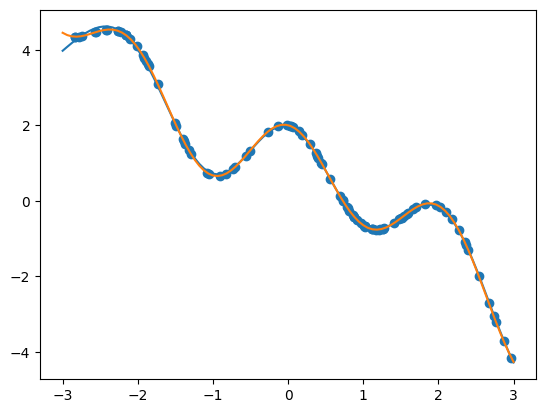

In [68]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, true_func(x))
ax.scatter(x_train, y_train)


### Suport Vector Classifier

In [2]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np

In [15]:
# データ生成
X, y = make_circles(n_samples=500, noise=0.05, factor=0.3, random_state=42)
print(X[y==0].shape)
print(X[y==1].shape)

(250, 2)
(250, 2)


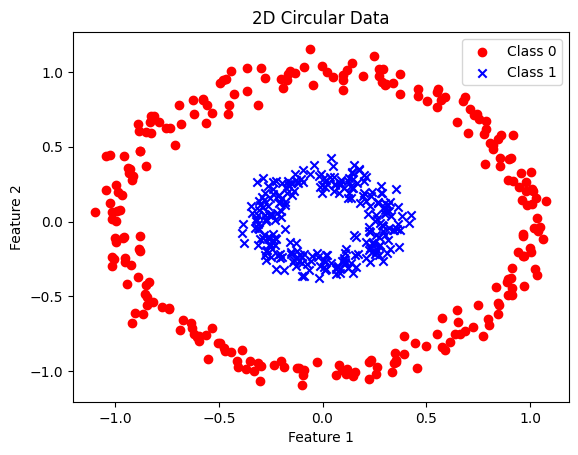

In [16]:
fig, ax = plt.subplots()

ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', marker='o', label='Class 0')
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='x', label='Class 1')
plt.legend()
plt.title('2D Circular Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [17]:
svm_poly = SVC(kernel='poly', degree=2, C=1)
svm_poly.fit(X, y)
support_vectors = svm_poly.support_vectors_
print(support_vectors)

[[-0.5349312  -0.71119699]
 [-0.31320758  0.78011152]
 [-0.87873094 -0.09652873]
 [-0.45417009  0.72173004]
 [ 0.78289666  0.3830468 ]
 [ 0.42620303  0.04505024]
 [ 0.04287937  0.42247895]
 [-0.28785418  0.29039916]
 [-0.31511373  0.26735512]]


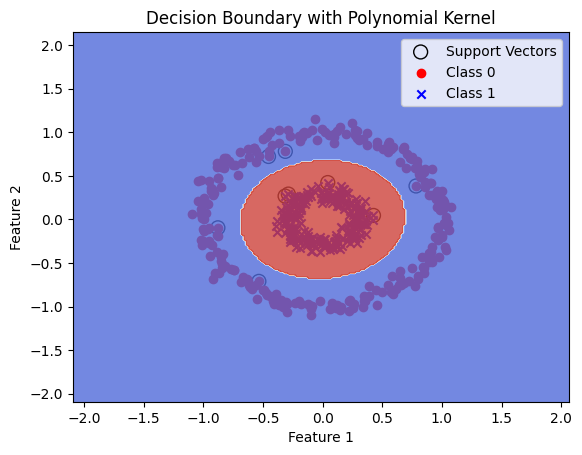

In [18]:
# 決定境界とサポートベクトルの描画関数
def plot_decision_boundary(X, y, model, support_vectors):
    # サポートベクトルのプロット
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')
    
    # データのプロット
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', marker='o', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='x', label='Class 1')

    # 決定境界のプロット
    h = .02  # ステップサイズ
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap="coolwarm")

    plt.legend()
    plt.title('Decision Boundary with Polynomial Kernel')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# 決定境界の描画
plot_decision_boundary(X, y, svm_poly, support_vectors)

## 6.3 RBFネットワーク

Chapter3 線形回帰モデルでは基底関数の選び方を考えていなかった\
#### 基底関数の選び方
- 動径基底関数がよく用いられる
- RBFはその中心$\mu_j$からの動径のみに依存している
$$
\phi_j(\bm{x}) = h(||\bm{x} - \bm{\mu}_j||)
$$
#### RBFを導入する動機
- 正確に目的変数の値を再現する関数補間\
目標変数のノイズによって過学習する可能性あり
$$
f(\bm{x}) = \sum_{n=1}^N w_n h(||\bm{x} - \bm{x}_n||)
$$
- 入力変数にノイズが含まれる場合の補間\
Nadaraya-Watsonモデル

- 入力変数に確率分布$\nu(\xi)$に従う確率変数$\xi$で表されるノイズが含まれる時、二乗和誤差関数は
$$
E = \frac{1}{2}\sum_{n=1}^{N} \int {\left\{ y(\bm{x}_n + \xi) - t_n \right\}^2}\nu(\xi) d\xi
$$
- yに対する変分法により\
基底関数は正規化されている
$$
y(\bm{x}_n) = \sum_{n=1}^{N} t_n h(\bm{x} - \bm{x}_n)\\
h(\bm{x} - \bm{x}_n) = \frac{\nu(\bm{x} - \bm{x}_n)}{\sum_{n=1}^{N} {\nu(\bm{x} - \bm{x}_n)}}
$$


### 6.3.1 Nadaraya-Watsonモデル

回帰関数は
$$
y(\bm{x}) = 
$$